## 任务1：读取汽车问答数据  
- 任务说明：理解数据集背景和读取数据集  
- 任务要求：下载数据集文件；使用工具解析PDF内容  


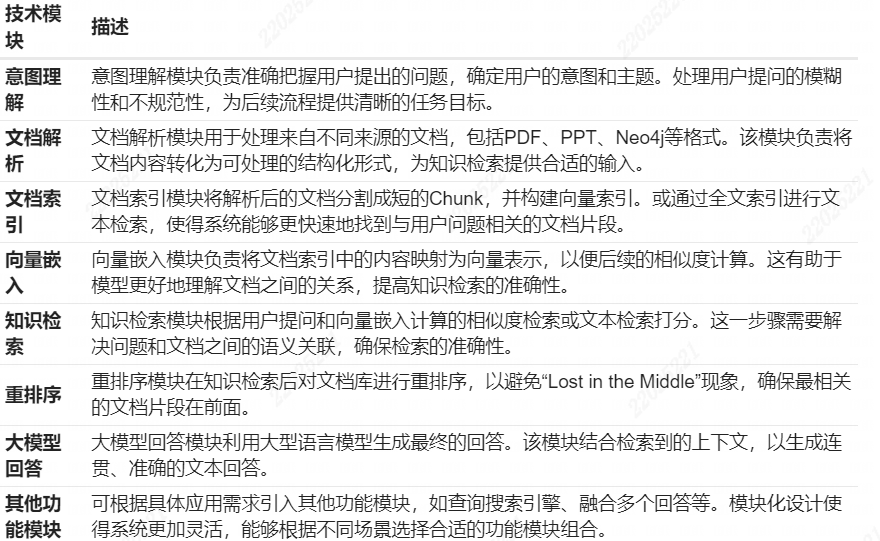

In [1]:
# !pip install pdfplumber -i https://pypi.tuna.tsinghua.edu.cn/simple
import json
import pdfplumber

In [2]:
questions = json.load(open("/gemini/data-1/questions.json"))
print(questions[0])

{'question': '“前排座椅通风”的相关内容在第几页？', 'answer': '', 'reference': ''}


In [23]:
questions[query_idx]

{'question': '请问在汽车技术中，1牛米（Nm）的力矩等于多少牛顿（N）乘以米（m）？',
 'answer': '',
 'reference': ''}

In [3]:
pdf = pdfplumber.open("/gemini/data-1/初赛训练数据集.pdf")
len(pdf.pages)  # 页数
pdf.pages[0].extract_text()  # 读取第一页内容

'欢迎\n感谢您选择了具有优良安全性、舒适性、动力性和经济性的Lynk&Co领克汽车。\n首次使用前请仔细、完整地阅读本手册内容，将有助于您更好地了解和使用车辆。\n本手册中的所有资料均为出版时的最新资料，但本公司将对产品进行不断的改进和优化，您所购的车辆可能与本手册中的描述有所不同，请以实际\n接收的车辆为准。\n如您有任何问题，或需要预约服务，请拨打电话4006-010101联系我们。您也可以开车前往Lynk&Co领克中心。\n在抵达之前，请您注意驾车安全。\n©领克汽车销售有限公司'

In [4]:
# 读取所有页内容
pdf_content = []
for page_idx in range(len(pdf.pages)):
    pdf_content.append({
        'page': 'page_' + str(page_idx + 1),
        'content': pdf.pages[page_idx].extract_text()
    })

In [7]:
pdf_content[11:14]

[{'page': 'page_12',
  'content': '前言\n■ 保持清醒的驾驶状态，切勿在饮酒或服药后驾驶车辆，否则会影 体记录数据项的含义及用途，见GB39732-2020《汽车事件数据记录\n响您对车辆的操控能力，可能引发事故，导致人员伤亡。 系统》标准中，表2A级数据元素的17个数据元素和说明。\n■ 请您务必谨慎驾驶，准确判断天气与路况是否适合出行，随时注\n意路面其他车辆或行人的动向，以便准确、及时地做出判断，防 当车辆发生碰撞事件时，当前事件数据可按事故数据存储的时间先后\n止意外事故的发生。 顺序覆盖之前非锁定事件数据。\n■ 驾驶时请务必保持全神贯注，在驾驶过程中接打电话、查看短信\n或是调节控制按钮等，都会分散您的注意力，可能引发事故，导\n事件数据信息能够帮助相关人员了解事件发生时车辆的状态，便于\n致人员伤亡。\nLynk&Co领克依照相关法律要求和其他规定行事。另外，在符合适用\n■ 请仔细阅读手册中相关的警告注意事项，无视这些内容可能会对 法律法规的前提下，这些信息还可用于工程研究，有助于Lynk&Co领\n驾乘人员造成人身伤害或导致车辆损坏。 克持续提升产品质量和安全性。\n联系Lynk&Co领克 根据国家立法和法规要求，Lynk&Co领克可能需要向某些权力机构\n（比如公安机关或其他有权访问事件数据记录系统的机构）披露相关\n如果您对本手册的内容有疑问，请通过以下方式联系Lynk&Co领克。 的记录数据。读取事件数据记录系统中的数据需要用到Lynk&Co领克\n汽车专用数据读取设备，通过专用设备连接车辆OBD接口或单独连接\nEDR控制器提取，仅与Lynk&Co领克订立协议的获批Lynk&Co领克中\n心可以使用。数据读取设备的获取途径：如果有必要，您可以联系\nLynk&Co领克客户联络中心 Lynk&Co领克授权经销商，在他们的协助下向制造商申请获取该设\n客户服务热线：4006-010101 备。\n远程监控系统\nLynk&Co领克汽车配备有远程监控系统，该系统用于采集并保存车辆\nLynk&Co领克 各种系统数据，如车速、位置、驱动电机、动力电池和报警信息等。\nhttp://www.lynkco.com\n远程监控系统定期将数据上传至Lynk&Co领克，这些数据将有助于对\n车辆进行保养/故障分析。同时，车

## 文本索引与答案检索

通过构建文本索引，解析后的文档分割成短的Chunk，并构建向量索引，通过全文索引进行文本检索，使得系统能够更快地找到与用户问题相关的文档片段

任务说明：文本文本索引的实现逻辑

任务要求
：    - 
理解倒排索    - 引
实现TFIDF和BM25的编码与检索

In [8]:
import jieba
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

In [9]:
# 对提问和PDF内容进行分词
question_words = [' '.join(jieba.lcut(x['question'])) for x in questions]
pdf_content_words = [' '.join(jieba.lcut(x['content'])) for x in pdf_content]   # 在分词过程中可以加入停用词，或者其他词，进行过滤

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.643 seconds.
Prefix dict has been built successfully.


In [10]:
tfidf = TfidfVectorizer()
tfidf.fit(question_words + pdf_content_words)

TfidfVectorizer()

In [11]:
# 提取TFIDF
question_feat = tfidf.transform(question_words)
pdf_content_feat = tfidf.transform(pdf_content_words)

In [12]:
# 进行归一化
question_feat = normalize(question_feat)
pdf_content_feat = normalize(pdf_content_feat)

In [17]:
pdf_content_feat.T

<4568x354 sparse matrix of type '<class 'numpy.float64'>'
	with 24066 stored elements in Compressed Sparse Column format>

score = feat @ pdf_content_feat.T 问题特征与文档特征之间点积是一种常用的相似性度量方法，这种操作背后的基本思想是，如果两个向量的点积越大，那么这两个向量越相似

In [26]:
# 检索进行排序
for query_idx, feat in enumerate(question_feat):
    score = feat @ pdf_content_feat.T # 点积
    score = score.toarray()[0]
    # print(score)
    max_score_page_idx = score.argsort()[-1] + 1
    # print(max_score_page_idx)
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

In [44]:
# 生成提交结果
# https://competition.coggle.club/
with open('submit.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

### BM25

BM25在信息检索中用于评估文档与查询之间的相关性

    BM25Okapi的主要参数：
    $k_1$：控制词项频率对分数的影响，通常设置为1.5。
    $b$：控制文档长度对分数的影响，通常设置为0.75。
    $epsilon$：用于防止逆文档频率（IDF）为负值的情况，通常设置为0.25
    
    打分计算过程：
    影响打分的三个因素：词项在文档中的频率（TF）、文档长度（doc_len）、逆文档频率（IDF）。文档长度对分数的影响通过b控制，文档长度越长，
    该项得分数越小，BM25Oapi的打分公式综合考虑以上三个因素，通过对每个词项的打分求和得到最终的文档与查询的相关性分数。

In [45]:
# !pip install rank_bm25
from rank_bm25 import BM25Okapi

pdf_content_words = [jieba.lcut(x['content']) for x in pdf_content]
bm25 = BM25Okapi(pdf_content_words)

for query_idx in range(len(questions)):
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]["question"]))
    max_score_page_idx = doc_scores.argsort()[-1] + 1
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

with open('submit1.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

# 文本嵌入与向量检索

语义检索是通过词嵌入和句子嵌入等技术，

### M3E

In [46]:
# !pip install -U sentence-transformers -i https://pypi.tuna.tsinghua.edu.cn/simple

In [47]:
from sentence_transformers import SentenceTransformer

In [48]:
model = SentenceTransformer("moka-ai/m3e-base")

In [49]:
question_sentences = [x['question'] for x in questions]
pdf_content_sentences = [x['content'] for x in pdf_content]

In [50]:
question_embeddings = model.encode(question_sentences, normalize_embeddings=True)
pdf_embeddings = model.encode(pdf_content_sentences, normalize_embeddings=True)

for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[-1] + 1
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

In [51]:
with open('submit.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

## 任务6：文本多路召回与重排序

    任务说明：实现多种文本编码和检索逻辑，并进行重排序
    任务要求：
    结合文本索引和向量检索结果
    加载重排序模型，对检索进行重排序

In [1]:
import jieba, json, pdfplumber
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from rank_bm25 import BM25Okapi

questions = json.load(open("/gemini/data-1/questions.json"))

pdf = pdfplumber.open("/gemini/data-1/初赛训练数据集.pdf")
pdf_content = []
for page_idx in range(len(pdf.pages)):
    pdf_content.append({
        'page': 'page_' + str(page_idx + 1),
        'content': pdf.pages[page_idx].extract_text()
    })

In [2]:
# # 将模型bge-reranker-base加载到相应目录
# from transformers import AutoModel

# # 指定模型的名称
# model_name = "BAAI/bge-reranker-base"

# # 指定缓存目录，即您希望下载模型的目录
# cache_dir = "../hugging-face-model/BAAI/bge-reranker-base/"

# # 下载模型到指定目录
# model = AutoModel.from_pretrained(model_name, cache_dir=cache_dir)

In [3]:
# 加载重排序模型
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-reranker-base')
rerank_model = AutoModelForSequenceClassification.from_pretrained('BAAI/bge-reranker-base')
rerank_model.cuda()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-26 12:37:44.019277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 12:37:44.019329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 12:37:44.020660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [4]:
pdf_content_words = [jieba.lcut(x['content']) for x in pdf_content]
bm25 = BM25Okapi(pdf_content_words)

for query_idx in range(len(questions)):
		# 首先进行BM25检索
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]["question"]))
    max_score_page_idxs = doc_scores.argsort()[-3:]
		
		# top3进行重排序
    pairs = []
    for idx in max_score_page_idxs:
        pairs.append([questions[query_idx]["question"], pdf_content[idx]['content']])

    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        inputs = {key: inputs[key].cuda() for key in inputs.keys()}
        scores = rerank_model(**inputs, return_dict=True).logits.view(-1, ).float()

    max_score_page_idx = max_score_page_idxs[scores.cpu().numpy().argmax()]
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx + 1)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.617 seconds.
Prefix dict has been built successfully.


In [5]:
with open('submit.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

## 任务7：文本问答Prompt优化

    任务说明：将检索结果结合问题构造promot，完成问答
    任务要求：
    构造prompt
    调用API进行问答

In [6]:
import time
import jwt
import requests
# 实际KEY，过期时间
def generate_token(apikey: str, exp_seconds: int):
    try:
        id, secret = apikey.split(".")
    except Exception as e:
        raise Exception("invalid apikey", e)

    payload = {
        "api_key": id,
        "exp": int(round(time.time() * 1000)) + exp_seconds * 1000,
        "timestamp": int(round(time.time() * 1000)),
    }
    return jwt.encode(
        payload,
        secret,
        algorithm="HS256",
        headers={"alg": "HS256", "sign_type": "SIGN"},
    )

def ask_glm(content):
    url = "https://open.bigmodel.cn/api/paas/v4/chat/completions"
    headers = {
      'Content-Type': 'application/json',
      'Authorization': generate_token("05d1fa443e3f3117f0e8ea03ca************MrJqlyIZjaFcKS6Z", 1000)
    }

    data = {
        "model": "glm-3-turbo",
        "messages": [{"role": "user", "content": content}]
    }

    response = requests.post(url, headers=headers, json=data)
    return response.json()


In [7]:
pdf_content_words = [jieba.lcut(x['content']) for x in pdf_content]
bm25 = BM25Okapi(pdf_content_words)

for query_idx in range(len(questions)):
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]["question"]))
    max_score_page_idxs = doc_scores.argsort()[-3:]

    pairs = []
    for idx in max_score_page_idxs:
        pairs.append([questions[query_idx]["question"], pdf_content[idx]['content']])

    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        inputs = {key: inputs[key].cuda() for key in inputs.keys()}
        scores = rerank_model(**inputs, return_dict=True).logits.view(-1, ).float()
    max_score_page_idx = max_score_page_idxs[scores.cpu().numpy().argmax()]
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx + 1)

    prompt = '''你是一个汽车专家，帮我结合给定的资料，回答一个问题。如果问题无法从资料中获得，请输出结合给定的资料，无法回答问题。
资料：{0}

问题：{1}
    '''.format(
        pdf_content[max_score_page_idx]['content'],
        questions[query_idx]["question"]
    )
    answer = ask_glm(prompt)['choices'][0]['message']['content']
    questions[query_idx]['answer'] = answer

In [8]:
with open('submit.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)